In [522]:
import ROOT
import uproot
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import awkward as ak

In [523]:
#Funzioni utili
def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

In [524]:
channel = 9 #Canale di cui si effettua l'analisi

In [525]:
#Tensione per considerare il segnale come saturato
Vt = np.array([-1.3, -1.3, -1.3, -1.3, -1.3, -1.3, -1.5, -1.3, 
               -1.3, -1.3, -1.3, -1.3, -1.3, -1.3, -1.3, -1.3]) #V
#Carica per filtrare spike ed eventi triggerati male
Q_max = np.array([-30, -30, -30, -30, -30, -30, -30, -30, 
                  -30, -30, -30, -30, -30, -30, -30, -30, ]) #pC
#Carica per filtrare cosmici
Q_min = np.array([-1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, 
                  -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, ]) #pC

Vt = Vt[channel]
Q_max = Q_max[channel]
Q_min = Q_min[channel]


In [526]:
PATH = '../Dati/27_03/Run_ch9_Cs_Measurements_Only_3_27_2024_0000.root' #Percorso relativo del file da analizzare
RunCs = uproot.open(PATH) #Apertura file da analizzare

noise_file = '../Dati/Noises/ch' + str(channel) + '.root'  #File di rumore di riferimento per il canale
RunNoise = uproot.open(noise_file)  #Apertura rumore

In [527]:
#Estrazione dati da file 

chargeCs = np.array(RunCs['tree'].arrays()['charge'])
ampCs = np.array(RunCs['tree'].arrays()['amp'])

chargeN = np.array(RunNoise['tree'].arrays()['charge'])
ampN = np.array(RunNoise['tree'].arrays()['amp'])

evCsT = np.array(RunCs['tree'].arrays()['ev'])[-1]
evNT = np.array(RunNoise['tree'].arrays()['ev'])[-1]

In [528]:
trueCs = ampCs>Vt  #Seleziono solo gli eventi che non saturano
chargeCs = chargeCs[trueCs]
ampCs=ampCs[trueCs]

trueCs = (chargeCs < Q_max) & (chargeCs > Q_min)
chargeCs = chargeCs[trueCs] #Seleziono solo gli eventi con una carica sotto una certa soglia
ampCs=ampCs[trueCs]         #così da trascurare spike ed eventi dovuti a trigger su altro canale


trueX = ampN>Vt             #Procedo allo stesso modo per "ripulire" il rumore
chargeN = chargeN[trueX]
ampN=ampN[trueX]

trueX = (chargeN < Q_max) & (chargeN > Q_min)
chargeN = chargeN[trueX]
ampN=ampN[trueX]

print("#Eventi ripuliti su ch " + str(channel) + " = " + str(len(chargeCs)))
print("#Noise ripulita su ch " + str(channel) + " = " + str(len(chargeN)))

#Eventi ripuliti su ch 9 = 913810
#Noise ripulita su ch 9 = 39579


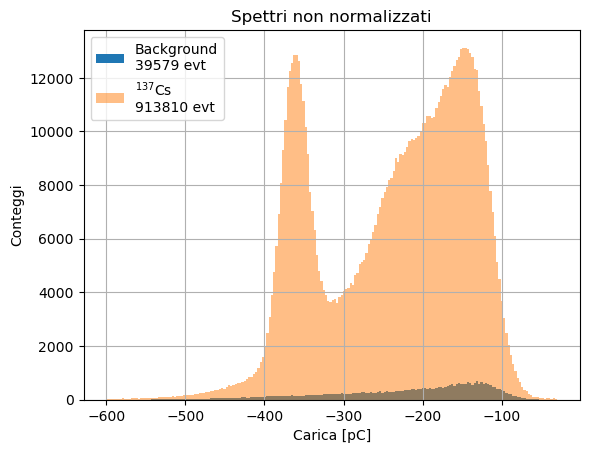

In [529]:
bin = 200 #Binnaggio scelto?

binN , edgeN , _= plt.hist(chargeN, bins=bin, range=(-600, Q_max), 
                           density = False, label = "Background\n" + str(len(chargeN)) + " evt")

binCs, edgeCs, _ = plt.hist(chargeCs, bins=bin, range=(-600, Q_max), 
                            density = False, label = r'$^{137}$Cs' + "\n" + str(len(chargeCs)) + " evt", alpha = 0.5)

plt.title("Spettri non normalizzati")
plt.ylabel("Conteggi")
plt.xlabel("Carica [pC]")
plt.grid()
plt.legend()
plt.show()

8.014895537084739


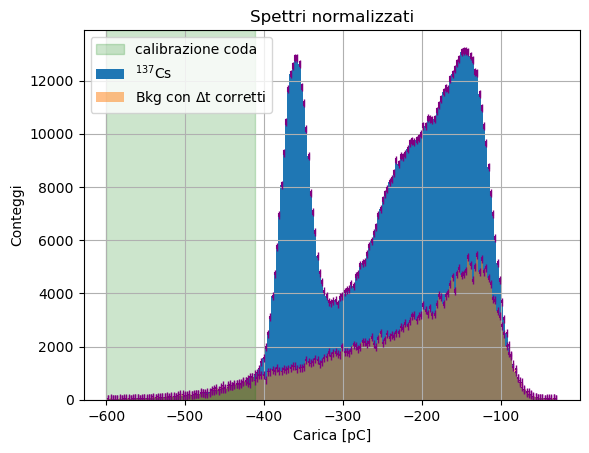

In [530]:
#Rinormalizzazione con media
avg_coda = ( binCs / binN)[:int(bin * 33 / 100)].mean()
print(avg_coda)
binN_Ren = binN* avg_coda #Moltiplicando per 1.5 viene molto meglio... mhhh

wdt = edgeN[1] - edgeN[0]
trash = plt.bar(edgeN[1:], binCs, width=wdt, label = r'$^{137}$Cs')
trash = plt.bar(edgeN[1:], binN_Ren, width=wdt, label = r'Bkg con $\Delta$t corretti', alpha = 0.5)

errCs = np.sqrt(binCs)
errN  = np.sqrt(binN_Ren)

trash = plt.errorbar(edgeN[1:], binN_Ren, errN, color='purple', fmt='|')
trash = plt.errorbar(edgeCs[1:], binCs, errCs, color='purple', fmt='|')

plt.axvspan(edgeN[0], edgeN[int(bin * 33 / 100)], color='green', alpha=0.2, label = "calibrazione coda")


plt.title("Spettri normalizzati")
plt.ylabel("Conteggi")
plt.xlabel("Carica [pC]")
plt.grid()
plt.legend()
plt.savefig("../Fig/Spettri_Normalizzati_.png")
plt.show()



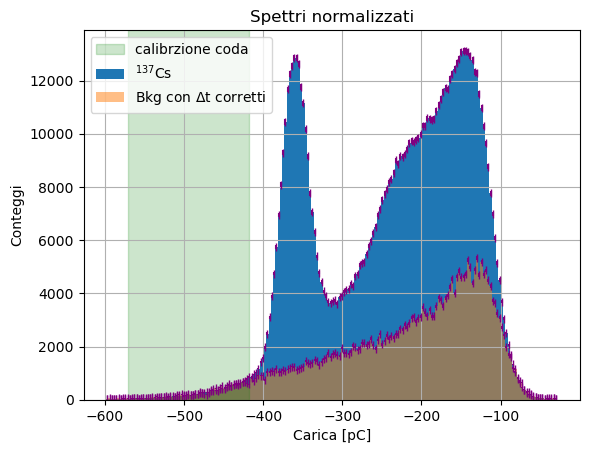

In [531]:
#Rinormalizzazione con integrale
rin_lim = [int(bin * 5 / 100), int(bin * 32 / 100)]
rin_f =  binCs[rin_lim[0]:rin_lim[1]].sum() / binN[rin_lim[0]:rin_lim[1]].sum()
binN_Ren = binN * rin_f #Moltiplicando per 1.5 viene molto meglio... mhhh

wdt = edgeN[1] - edgeN[0]
trash = plt.bar(edgeN[1:], binCs, width=wdt, label = r'$^{137}$Cs')
trash = plt.bar(edgeN[1:], binN_Ren, width=wdt, label = r'Bkg con $\Delta$t corretti', alpha = 0.5)

errCs = np.sqrt(binCs)
errN  = np.sqrt(binN_Ren)

trash = plt.errorbar(edgeN[1:], binN_Ren, errN, color='purple', fmt='|')
trash = plt.errorbar(edgeCs[1:], binCs, errCs, color='purple', fmt='|')

plt.axvspan(edgeN[rin_lim[0]], edgeN[rin_lim[1]], color='green', alpha=0.2, label = "calibrzione coda")


plt.title("Spettri normalizzati")
plt.ylabel("Conteggi")
plt.xlabel("Carica [pC]")
plt.grid()
plt.legend()
plt.savefig("../Fig/Spettri_Normalizzati_.png")
plt.show()



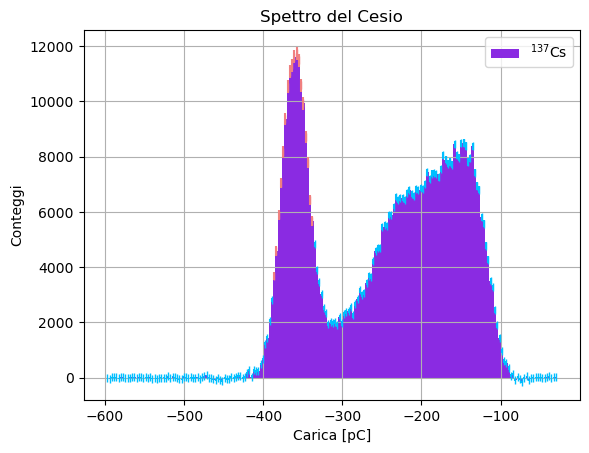

In [532]:
wdt = edgeN[1] - edgeN[0]
binSign = binCs - binN_Ren

trash = plt.bar(edgeN[1:],binSign,width = wdt, label = r'$^{137}$Cs', color = "blueviolet")

err = np.sqrt(binCs  + binN_Ren )
err_noise=np.sqrt(binN_Ren)
#Determinazione del picco
peak_cntr = np.argmax(binSign)
peak_ledge = peak_cntr - 10
peak_redge = peak_cntr + 8


trash = plt.errorbar(edgeN[1:peak_ledge+1], binSign[:peak_ledge], err[:peak_ledge], color='deepskyblue', fmt='|')
trash = plt.errorbar(edgeN[peak_redge+1:], binSign[peak_redge:], err[peak_redge:], color='deepskyblue', fmt='|')

trash = plt.errorbar(edgeN[peak_ledge+1:peak_redge+1], 
                     binSign[peak_ledge:peak_redge], 
                     2*err[peak_ledge:peak_redge], 
                     color='lightcoral', fmt='|')



plt.title("Spettro del Cesio")
plt.ylabel("Conteggi")
plt.xlabel("Carica [pC]")
plt.grid()
plt.legend()
plt.savefig("../Fig/Spettro_Cs.png")
plt.show()


Valor medio = -363.6pC
Dev std = 12.8pC


/var/folders/17/9cj0cbps58xbmrl2zpj6hv2h0000gn/T/ipykernel_67694/3645634194.py:30: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(x_values, gaussian(x_values, *popt_gaus), 'r-', label='Fit: A=%5.3f, $\mu$=%5.3f, $\sigma$=%5.3f' % tuple(popt_gaus), ls = "-.")


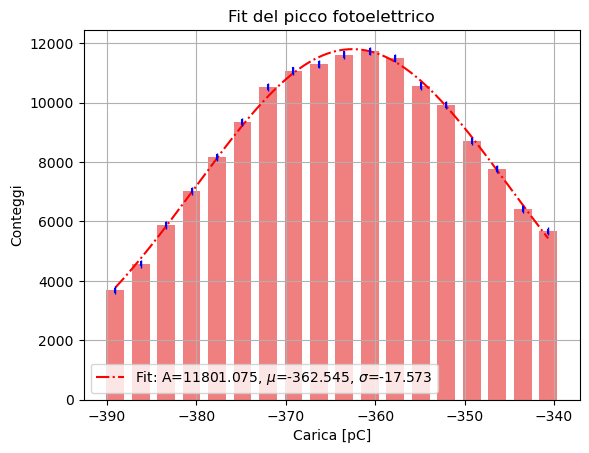

Chi-quadro: 35.937264224471306
dof: 18


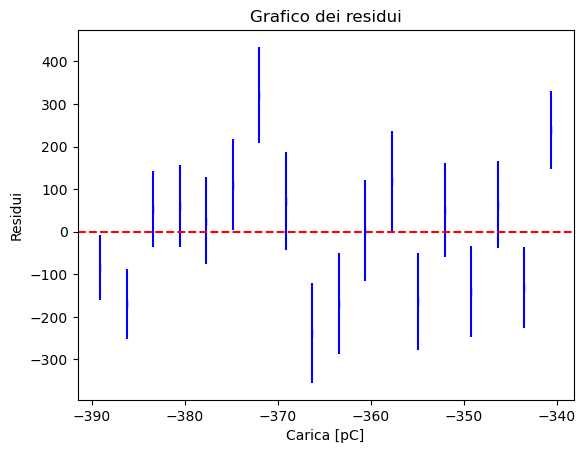

In [533]:
from scipy.optimize import curve_fit
#Isolo la parte di spettro legata al fotoelettrico
edge_photo=edgeN[peak_ledge:peak_redge]
counts_photo=binSign[peak_ledge:peak_redge]
err_photo=err[peak_ledge:peak_redge]

#bin_centers = (edge_photo[:-1] + edge_photo[1:]) / 2
bin_centers=edge_photo
# Calcoliamo il valore rappresentativo pesato dai conteggi di ciascun bin
weighted_values = bin_centers * counts_photo

# Calcoliamo la media pesata
weighted_mean = np.sum(weighted_values) / np.sum(counts_photo)

# Calcoliamo la deviazione standard pesata
weighted_std = np.sqrt(np.sum(counts_photo * (bin_centers - weighted_mean)**2) / np.sum(counts_photo))

print("Valor medio = " + str(round(weighted_mean, 1)) + "pC")
print("Dev std = " + str(round(weighted_std, 1)) + "pC")



# Facciamo il fit della gaussiana ai dati
popt_gaus, pcov = curve_fit(gaussian, bin_centers, counts_photo, p0=[1, weighted_mean, weighted_std], sigma=err_photo,
                        maxfev = 5000)

# Plot dell'istogramma e della curva di fit
plt.bar(edge_photo,counts_photo,width=2, color = "lightcoral")
x_values=np.linspace(np.min(edge_photo), np.max(edge_photo), 200)
plt.plot(x_values, gaussian(x_values, *popt_gaus), 'r-', label='Fit: A=%5.3f, $\mu$=%5.3f, $\sigma$=%5.3f' % tuple(popt_gaus), ls = "-.")
plt.errorbar(edge_photo, counts_photo, err_photo, color='blue', fmt='|')
plt.legend()
plt.xlabel('Carica [pC]')
plt.ylabel('Conteggi')
plt.title("Fit del picco fotoelettrico")
plt.grid()
plt.savefig("../Fig/Picco_Cs.png")
plt.show()


#fare chi quadro e residui
valori_previsti = gaussian(edge_photo, *popt_gaus)

# 2. Calcola il chi-quadro
chi_quadro = np.sum(((counts_photo - valori_previsti) / err_photo)**2)

print("Chi-quadro:", chi_quadro)
print("dof:", np.size(counts_photo))

# 3. Calcola i residui
residui = counts_photo - valori_previsti

# 4. Traccia il grafico dei residui
plt.errorbar(edge_photo, residui, err_photo,color='blue', fmt='|')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Carica [pC]')
plt.ylabel('Residui')
plt.title('Grafico dei residui')
plt.show()

stima1=popt_gaus[1]
inc1=pcov[1][1]

In [534]:
#edge_photo in realtà contiene i centri dei bin
mean = np.average(edge_photo, weights=counts_photo)
# Trova la moda
conteggi_max = max(counts_photo)
mode_result = [valore for valore, conteggio in zip(edge_photo, counts_photo) if conteggio == conteggi_max]

# Calcola la mediana
sorted_data = sorted([valore for valore, conteggio in zip(edge_photo, counts_photo) for _ in range(int(conteggio))])
n = len(sorted_data)
if n % 2 == 0:
    median_result = (sorted_data[n//2 - 1] + sorted_data[n//2]) / 2
else:
    median_result = sorted_data[n//2]

print("Media:", mean)
print("Moda:", mode_result)
print("Mediana:", median_result)

Media: -363.63013027570844
Moda: [-360.6000061035156]
Mediana: -363.45001220703125


# Provo a fittare l'intero spettro 

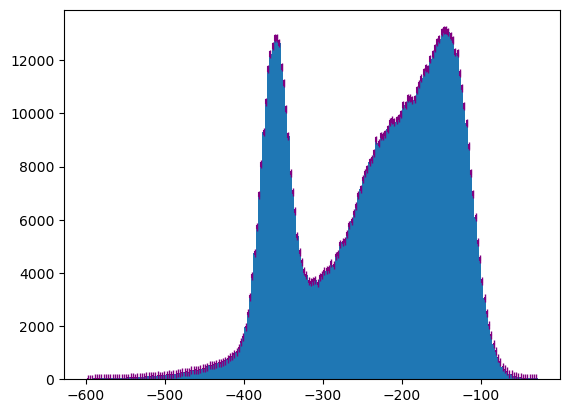

In [535]:
trash = plt.errorbar(edgeCs[1:], binCs, errCs, color='purple', fmt='|')
trash = plt.bar(edgeN[1:], binCs, width=wdt, label = r'$^{137}$Cs')

/var/folders/17/9cj0cbps58xbmrl2zpj6hv2h0000gn/T/ipykernel_67694/1261244348.py:2: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  gaus_func=plt.plot(x_values, gaussian(x_values, *popt_gaus), 'r-', label='Fit: A=%5.3f, $\mu$=%5.3f, $\sigma$=%5.3f' % tuple(popt_gaus), ls = "-.")


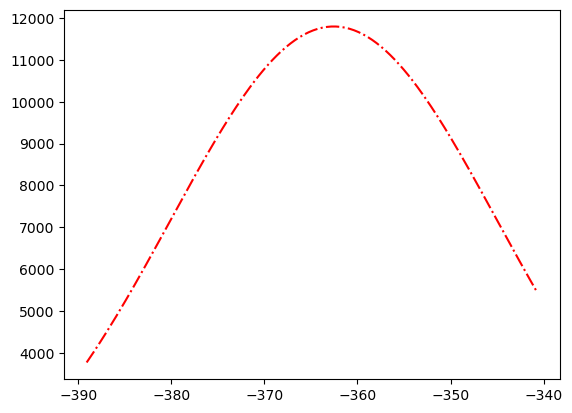

In [536]:
x_values=np.linspace(np.min(edge_photo), np.max(edge_photo), 200)
gaus_func=plt.plot(x_values, gaussian(x_values, *popt_gaus), 'r-', label='Fit: A=%5.3f, $\mu$=%5.3f, $\sigma$=%5.3f' % tuple(popt_gaus), ls = "-.")


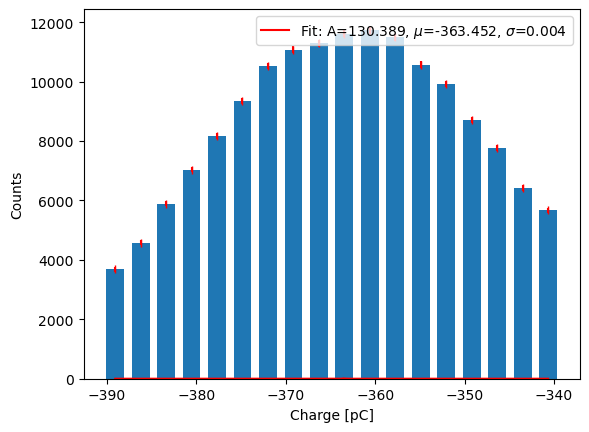

In [537]:
def lorentzian(x, A, x0, L):
    return A / (2 * np.pi) * L / ((x - x0)**2 + (0.5 * L)**2)


popt, pcov = curve_fit(lorentzian, bin_centers, counts_photo, p0=[1, weighted_mean, weighted_std], sigma=err_photo)

# Plot dell'istogramma e della curva di fit
#plt.hist(dati, bins=30, density=True, alpha=0.5, color='b', label='Istogramma dei dati')
plt.bar(edge_photo,counts_photo,width=2)
x_values=np.linspace(np.min(edge_photo), np.max(edge_photo), 200)
plt.plot(x_values, lorentzian(x_values, *popt), 'r-', label='Fit: A=%5.3f, $\mu$=%5.3f, $\sigma$=%5.3f' % tuple(popt))
plt.errorbar(edge_photo, counts_photo, err_photo, color='red', fmt='|')
plt.legend()
plt.xlabel('Charge [pC]')
plt.ylabel('Counts')
plt.show()

Chi-quadro: 112841.59564041067
dof: 18


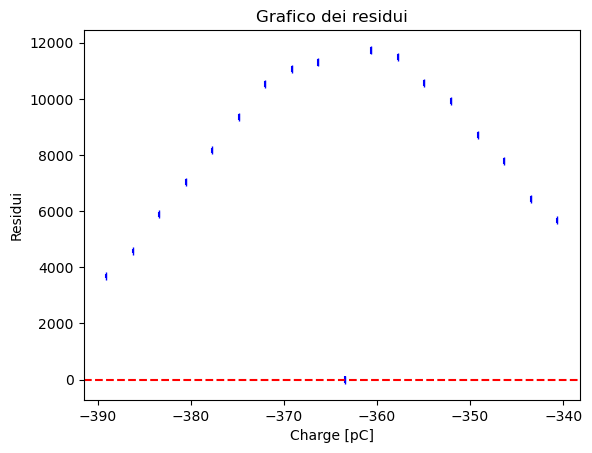

In [538]:
#fare chi quadro e residui
valori_previsti = lorentzian(edge_photo, *popt)

# 2. Calcola il chi-quadro
chi_quadro = np.sum(((counts_photo - valori_previsti) / err_photo)**2)

print("Chi-quadro:", chi_quadro)
print("dof:", np.size(counts_photo))

# 3. Calcola i residui
residui = counts_photo - valori_previsti

# 4. Traccia il grafico dei residui
plt.errorbar(edge_photo, residui, err_photo,color='blue', fmt='|')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Charge [pC]')
plt.ylabel('Residui')
plt.title('Grafico dei residui')
plt.show()

# Fit a rumore (esponenziale)

[ 2.24877995e+05  5.78887475e-03 -1.77105766e-03  5.12507089e+02] [[ 2.02848125e+22 -3.65459936e+06  1.59755831e+14  1.55822405e+19]
 [-3.65459936e+06  3.27648998e-08 -2.87822751e-02 -2.80736758e+03]
 [ 1.59755831e+14 -2.87822751e-02  1.25817903e+06  1.22720079e+11]
 [ 1.55822405e+19 -2.80736758e+03  1.22720079e+11  1.19698528e+16]]


/var/folders/17/9cj0cbps58xbmrl2zpj6hv2h0000gn/T/ipykernel_67694/4055797426.py:23: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(x_values, exponential(x_values, popt_exp[0], popt_exp[1], popt_exp[2], popt_exp[3]), 'r-', label='Fit: ', ls = "-.")


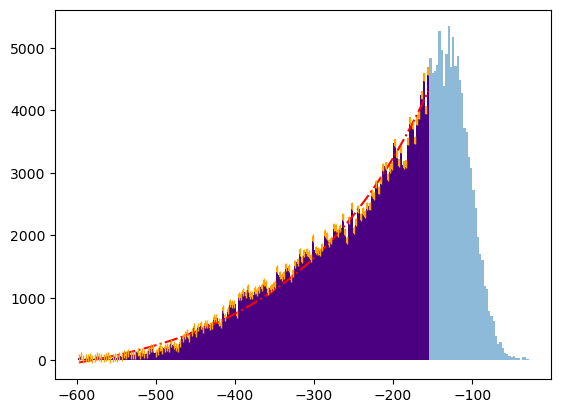

In [539]:
def exponential(x, a, b, c, x0):
    return a*(np.exp(b*(x-x0)) + c)

edgeN=edgeN[1:]
#edgeN=-edgeN
trash = plt.bar(edgeN, binN_Ren, width=wdt, label = r'Bkg con $\Delta$t corretti', alpha = 0.5)
#trash = plt.bar(edgeN[:int(bin*78/100)], binN_Ren[:int(bin*78/100)], width=wdt, label = r'Da fittare', color='indigo')
edgeN_tofit = np.concatenate((edgeN[:peak_ledge], edgeN[peak_redge+20:int(bin*78/100)]))  # Concatena i due segmenti esterni
binN_tofit=np.concatenate((binN_Ren[:peak_ledge], binN_Ren[peak_redge+20:int(bin*78/100)]))
err_tofit=np.concatenate((err_noise[:peak_ledge], err_noise[peak_redge+20:int(bin*78/100)]))

####
edgeN_tofit = np.concatenate((edgeN[:peak_ledge], edgeN[peak_ledge:int(bin*78/100)]))  # Concatena i due segmenti esterni
binN_tofit=np.concatenate((binN_Ren[:peak_ledge], binN_Ren[peak_ledge:int(bin*78/100)]))
err_tofit=np.concatenate((err_noise[:peak_ledge], err_noise[peak_ledge:int(bin*78/100)]))
####
_ = plt.bar(edgeN_tofit, binN_tofit, width=wdt, label = r'Da fittare', color='indigo')
plt.errorbar(edgeN_tofit, binN_tofit, err_tofit, label = r'Da fittare', color='orange', fmt='|')
popt_exp, pcov = curve_fit(exponential, edgeN_tofit, binN_tofit, sigma=err_tofit,p0=[40000,np.log(2)/150, 0, 0])

print(popt_exp, pcov)
x_values=np.linspace(np.min(edgeN_tofit), np.max(edgeN_tofit), 200)
plt.plot(x_values, exponential(x_values, popt_exp[0], popt_exp[1], popt_exp[2], popt_exp[3]), 'r-', label='Fit: ', ls = "-.")


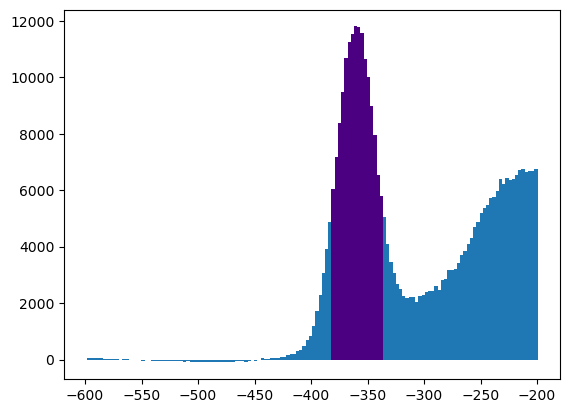

In [540]:
estimated_noise=exponential(edgeN, popt_exp[0], popt_exp[1], popt_exp[2], popt_exp[3])
bin_signal=binCs-estimated_noise
trash = plt.bar(edgeN[:int(bin*70/100)], bin_signal[:int(bin*70/100)], width=wdt, label = r'$^{137}$Cs')
trash = plt.bar(edgeN[int(bin*38/100):int(bin*46/100)], bin_signal[int(bin*38/100):int(bin*46/100)], width=wdt, label = r'$^{137}$Cs', color='indigo')

Valor medio = -359.4pC
Dev std = 11.8pC


/var/folders/17/9cj0cbps58xbmrl2zpj6hv2h0000gn/T/ipykernel_67694/1009295540.py:28: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(x_values, gaussian(x_values, *popt), 'r-', label='Fit: A=%5.3f, $\mu$=%5.3f, $\sigma$=%5.3f' % tuple(popt), ls = "-.")


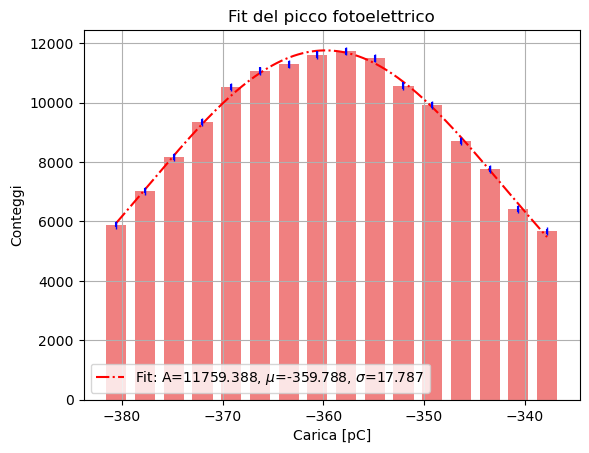

Chi-quadro: 25.855169618219875
dof: 16


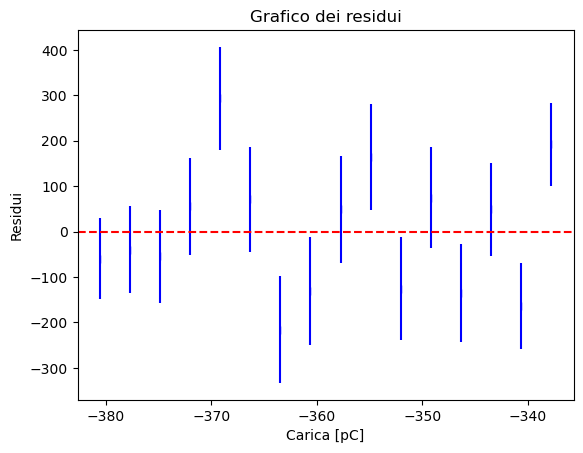

In [541]:
edge_photo=edgeN[int(bin*38/100):int(bin*46/100)]
counts_photo=binSign[int(bin*38/100):int(bin*46/100)]
err_photo=err[int(bin*38/100):int(bin*46/100)]

#bin_centers = (edge_photo[:-1] + edge_photo[1:]) / 2
bin_centers=edge_photo
# Calcoliamo il valore rappresentativo pesato dai conteggi di ciascun bin
weighted_values = bin_centers * counts_photo

# Calcoliamo la media pesata
weighted_mean = np.sum(weighted_values) / np.sum(counts_photo)

# Calcoliamo la deviazione standard pesata
weighted_std = np.sqrt(np.sum(counts_photo * (bin_centers - weighted_mean)**2) / np.sum(counts_photo))

print("Valor medio = " + str(round(weighted_mean, 1)) + "pC")
print("Dev std = " + str(round(weighted_std, 1)) + "pC")



# Facciamo il fit della gaussiana ai dati
popt, pcov = curve_fit(gaussian, bin_centers, counts_photo, p0=[1, weighted_mean, weighted_std], sigma=err_photo,
                        maxfev = 5000)

# Plot dell'istogramma e della curva di fit
plt.bar(edge_photo,counts_photo,width=2, color = "lightcoral")
x_values=np.linspace(np.min(edge_photo), np.max(edge_photo), 200)
plt.plot(x_values, gaussian(x_values, *popt), 'r-', label='Fit: A=%5.3f, $\mu$=%5.3f, $\sigma$=%5.3f' % tuple(popt), ls = "-.")
plt.errorbar(edge_photo, counts_photo, err_photo, color='blue', fmt='|')
plt.legend()
plt.xlabel('Carica [pC]')
plt.ylabel('Conteggi')
plt.title("Fit del picco fotoelettrico")
plt.grid()
plt.savefig("../Fig/Picco_Cs.png")
plt.show()

#fare chi quadro e residui
valori_previsti = gaussian(edge_photo, *popt)

# 2. Calcola il chi-quadro
chi_quadro = np.sum(((counts_photo - valori_previsti) / err_photo)**2)

print("Chi-quadro:", chi_quadro)
print("dof:", np.size(counts_photo))

# 3. Calcola i residui
residui = counts_photo - valori_previsti

# 4. Traccia il grafico dei residui
plt.errorbar(edge_photo, residui, err_photo,color='blue', fmt='|')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Carica [pC]')
plt.ylabel('Residui')
plt.title('Grafico dei residui')
plt.show()

stima2=popt[1]
inc2=pcov[1][1]

# Fit al picco senza togliere il rumore sotto

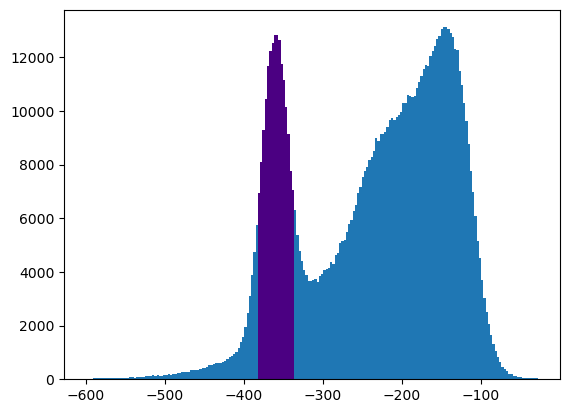

In [542]:
trash = plt.bar(edgeN, binCs, width=wdt, label = r'$^{137}$Cs')
trash = plt.bar(edgeN[int(bin*38/100):int(bin*46/100)], binCs[int(bin*38/100):int(bin*46/100)], width=wdt, label = r'$^{137}$Cs', color='indigo')

Valor medio = -359.4pC
Dev std = 11.8pC


/var/folders/17/9cj0cbps58xbmrl2zpj6hv2h0000gn/T/ipykernel_67694/1158411191.py:28: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(x_values, gaussian(x_values, *popt), 'r-', label='Fit: A=%5.3f, $\mu$=%5.3f, $\sigma$=%5.3f' % tuple(popt), ls = "-.")


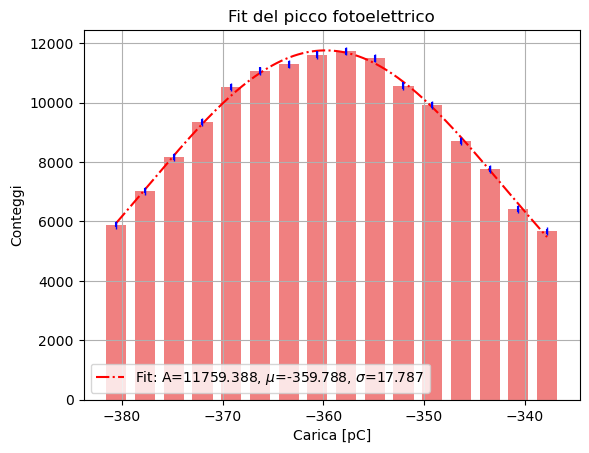

Chi-quadro: 25.855169618219875
dof: 16


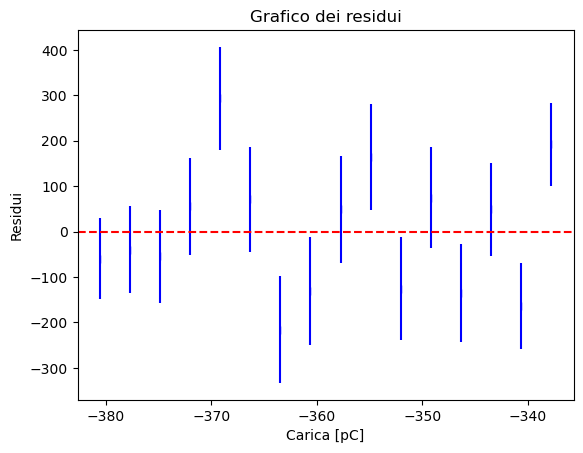

In [543]:
edge_photo=edgeN[int(bin*38/100):int(bin*46/100)]
counts_photo=binSign[int(bin*38/100):int(bin*46/100)]
err_photo=err[int(bin*38/100):int(bin*46/100)]

#bin_centers = (edge_photo[:-1] + edge_photo[1:]) / 2
bin_centers=edge_photo
# Calcoliamo il valore rappresentativo pesato dai conteggi di ciascun bin
weighted_values = bin_centers * counts_photo

# Calcoliamo la media pesata
weighted_mean = np.sum(weighted_values) / np.sum(counts_photo)

# Calcoliamo la deviazione standard pesata
weighted_std = np.sqrt(np.sum(counts_photo * (bin_centers - weighted_mean)**2) / np.sum(counts_photo))

print("Valor medio = " + str(round(weighted_mean, 1)) + "pC")
print("Dev std = " + str(round(weighted_std, 1)) + "pC")



# Facciamo il fit della gaussiana ai dati
popt, pcov = curve_fit(gaussian, bin_centers, counts_photo, p0=[1, weighted_mean, weighted_std], sigma=err_photo,
                        maxfev = 5000)

# Plot dell'istogramma e della curva di fit
plt.bar(edge_photo,counts_photo,width=2, color = "lightcoral")
x_values=np.linspace(np.min(edge_photo), np.max(edge_photo), 200)
plt.plot(x_values, gaussian(x_values, *popt), 'r-', label='Fit: A=%5.3f, $\mu$=%5.3f, $\sigma$=%5.3f' % tuple(popt), ls = "-.")
plt.errorbar(edge_photo, counts_photo, err_photo, color='blue', fmt='|')
plt.legend()
plt.xlabel('Carica [pC]')
plt.ylabel('Conteggi')
plt.title("Fit del picco fotoelettrico")
plt.grid()
plt.savefig("../Fig/Picco_Cs.png")
plt.show()

#fare chi quadro e residui
valori_previsti = gaussian(edge_photo, *popt)

# 2. Calcola il chi-quadro
chi_quadro = np.sum(((counts_photo - valori_previsti) / err_photo)**2)

print("Chi-quadro:", chi_quadro)
print("dof:", np.size(counts_photo))

# 3. Calcola i residui
residui = counts_photo - valori_previsti

# 4. Traccia il grafico dei residui
plt.errorbar(edge_photo, residui, err_photo,color='blue', fmt='|')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Carica [pC]')
plt.ylabel('Residui')
plt.title('Grafico dei residui')
plt.show()

stima3=popt[1]
inc3=pcov[1][1]

# Sumup dei risultati dei vari fit

In [544]:
print("Stima con normalizzazione integrale: ", stima1, inc1)
print("Stima con fit del fondo: ", stima2, inc2)
print("Stima senza togliere il fondo: ", stima3, inc3)

Stima con normalizzazione integrale:  -362.5451990557474 0.013049518446666979
Stima con fit del fondo:  -359.7877901617694 0.012989127040030708
Stima senza togliere il fondo:  -359.7877901617694 0.012989127040030708


In [545]:
def Spectrum_Shape(x, Cg, mu, sigma, Ce, b, c, x0):
     return Cg* np.exp(-(x - mu)**2 / (2 * sigma**2)) + Ce*(np.exp(b*(x-x0)) + c)

#Proviamo con la CrystalBall al posto della gaussiana
from scipy.stats import crystalball

def Spectrum_Shape_2(x, Cg, mu, beta, m, Ce, b, c, x0):
     return Cg* crystalball.pdf(x, beta, m, loc=mu) + Ce*(np.exp(b*(x-x0)) + c)

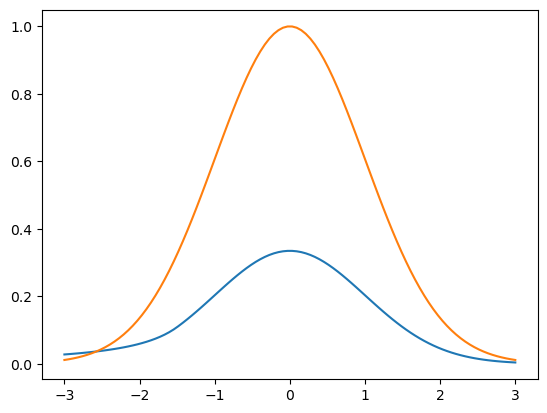

In [546]:
xval=np.linspace(-3,3, 100)
plt.plot(xval, crystalball.pdf(xval, 1.5, 1.5))
plt.plot(xval, gaussian(xval, 1, 0, 1))

In [547]:
#aggiungiamo la fermi-dirac

def Spectrum_Shape(x, Cg, mu, sigma, Ce, b, c, x0, Cf, A, x1):
     return Cg* np.exp(-(x - mu)**2 / (2 * sigma**2)) + Ce*(np.exp(b*(x-x0)) + c) + Cf*(1/(1 + np.exp(A*(x1-x))))


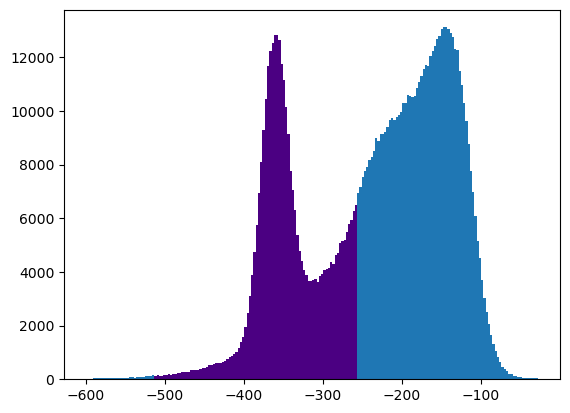

In [548]:
trash = plt.bar(edgeN, binCs, width=wdt, label = r'$^{137}$Cs')
trash = plt.bar(edgeN[int(bin*15/100):int(bin*60/100)], binCs[int(bin*15/100):int(bin*60/100)], width=wdt, label = r'$^{137}$Cs', color='indigo')



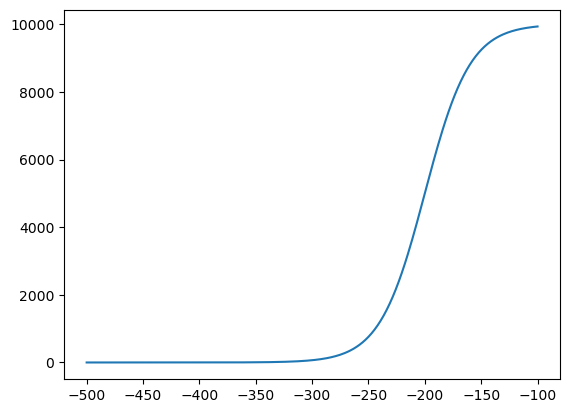

In [549]:
def FermiDirac(x, N, A, x0):
    return N*(1/(1 + np.exp(A*(x0-x))))

xval=np.linspace(-500, -100, 300)
plt.plot(xval, FermiDirac(xval, 10000, 0.05, -200))

[ 1.12046530e+04 -3.60366199e+02 -1.70451907e+01  1.35198614e+04
  1.00103554e-02 -9.11815727e-03  1.07734981e+03  2.27861366e+04
  1.43075427e-02 -1.92312487e+02]


/var/folders/17/9cj0cbps58xbmrl2zpj6hv2h0000gn/T/ipykernel_67694/620845930.py:4: RuntimeWarning: overflow encountered in exp
  return Cg* np.exp(-(x - mu)**2 / (2 * sigma**2)) + Ce*(np.exp(b*(x-x0)) + c) + Cf*(1/(1 + np.exp(A*(x1-x))))
/var/folders/17/9cj0cbps58xbmrl2zpj6hv2h0000gn/T/ipykernel_67694/2221847582.py:15: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(x_values, Spectrum_Shape(x_values, *popt), 'r-', label='Fit', ls = "-.")


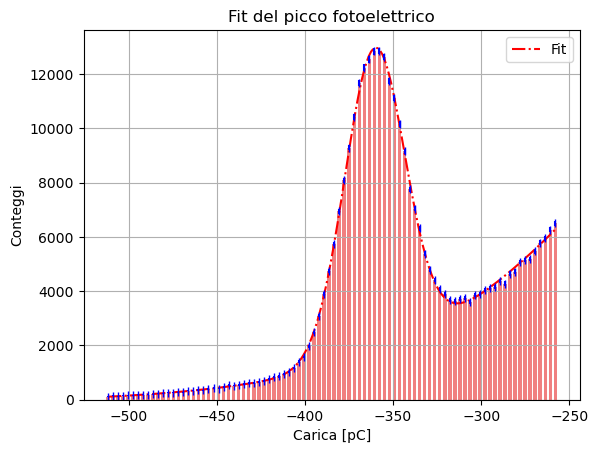

Chi-quadro: 111.28859966125589
dof: 90


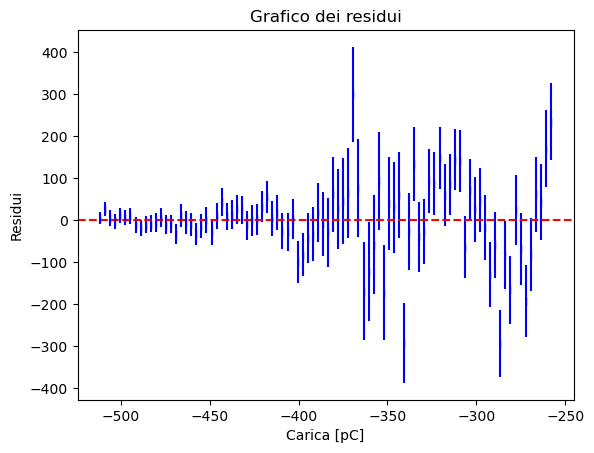

In [550]:
edge_photo=edgeN[int(bin*15/100):int(bin*60/100)]
counts_photo=binCs[int(bin*15/100):int(bin*60/100)]
err_photo=err[int(bin*15/100):int(bin*60/100)]
bin_centers=edge_photo
# Facciamo il fit della funzione ai dati

popt, pcov = curve_fit(Spectrum_Shape, bin_centers, counts_photo, p0=[popt_gaus[0], popt_gaus[1], popt_gaus[2], popt_exp[0], popt_exp[1], popt_exp[2], popt_exp[3], 10000, 0.05, -200], sigma=err_photo,
                        maxfev = 5000)


print(popt)
# Plot dell'istogramma e della curva di fit
plt.bar(edge_photo,counts_photo,width=2, color = "lightcoral")
x_values=np.linspace(np.min(edge_photo), np.max(edge_photo), 200)
plt.plot(x_values, Spectrum_Shape(x_values, *popt), 'r-', label='Fit', ls = "-.")
plt.errorbar(edge_photo, counts_photo, err_photo, color='blue', fmt='|')
plt.legend()
plt.xlabel('Carica [pC]')
plt.ylabel('Conteggi')
plt.title("Fit del picco fotoelettrico")
plt.grid()
plt.savefig("../Fig/Picco_Cs.png")
plt.show()

#fare chi quadro e residui
valori_previsti = Spectrum_Shape(edge_photo, *popt)

# 2. Calcola il chi-quadro
chi_quadro = np.sum(((counts_photo - valori_previsti) / err_photo)**2)

print("Chi-quadro:", chi_quadro)
print("dof:", np.size(counts_photo))

# 3. Calcola i residui
residui = counts_photo - valori_previsti

# 4. Traccia il grafico dei residui
plt.errorbar(edge_photo, residui, err_photo,color='blue', fmt='|')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Carica [pC]')
plt.ylabel('Residui')
plt.title('Grafico dei residui')
plt.show()